# This notebook compares a to-do list created via a LangChain Single-Shot Agent with a LangChain agent that has the executor step substituted with BabyAGI. This is to compare quality and the speed of a simple vs. complex AI agent. As you will see the complex agent that uses BabyAGI + LangChain+ Tools to create a to-do list (to prove aliens are real through multiple iterations) is the more relevant and detailed list.

In [ ]:
!pip install langchain openai tiktoken faiss-cpu google-search-results  -q #Install and Import Required Modules


In [ ]:
import os

os.environ["OPENAI_API_KEY"] = ""  # https://platform.openai.com
os.environ['SERPAPI_API_KEY'] = "" # https://serpapi.com/

## LangChain Single Shot Agent


In [ ]:
from langchain.agents import load_tools
from langchain.agents import initialize_agent
from langchain.agents import AgentType
from langchain.llms import OpenAI

In [ ]:
llm = OpenAI(temperature=0) # First, let's load the language model we're going to use to control the agent.

In [ ]:
tools = load_tools(["serpapi"], llm=llm) #Next, let's load some tools to use.

In [ ]:

agent = initialize_agent(tools, llm, agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION, verbose=True) #Finally, let's initialize an agent with the tools, the language model, and the type of agent we want to use.

In [ ]:
agent.run("You work for a non profit organization titled Aliens are Real that is trying to find UFOs and aliens among us and give them a warm welcome to Earth. Your goal is to prove Aliens are real through research, first hand accounts, and evidence of extraterrestrial and/or intradimensional life. Your first task in providing evidence that aliens exist is to make a todo list to map out your steps in order to prove aliens are real") #Now let's test it out!




> Entering new AgentExecutor chain...
 I need to research and find evidence of aliens
Action: Search
Action Input: Evidence of aliens
Observation: A Pentagon spokesperson has denied the claims, while lawmakers are pushing for information on UFOs to be declassified.
Thought: I need to find first hand accounts of aliens
Action: Search
Action Input: First hand accounts of aliens
Observation: Three military veterans testified in Congress' highly anticipated hearing on UFOs Wednesday, including a former Air Force intelligence ...
Thought: I need to find research on extraterrestrial and/or intradimensional life
Action: Search
Action Input: Research on extraterrestrial and/or intradimensional life
Observation: But that extraterrestrial presence on regular display is, of course, a fiction. No life beyond Earth has ever been found; there is no evidence that alien life ...
Thought: I now know the steps I need to take to prove aliens are real
Final Answer: To prove aliens are real, I need to re

'To prove aliens are real, I need to research and find evidence of aliens, find first hand accounts of aliens, and find research on extraterrestrial and/or intradimensional life.'

# BabyAGI with Tools

This notebook builds on top of [baby agi](baby_agi.ipynb), but shows how you can swap out the execution chain. 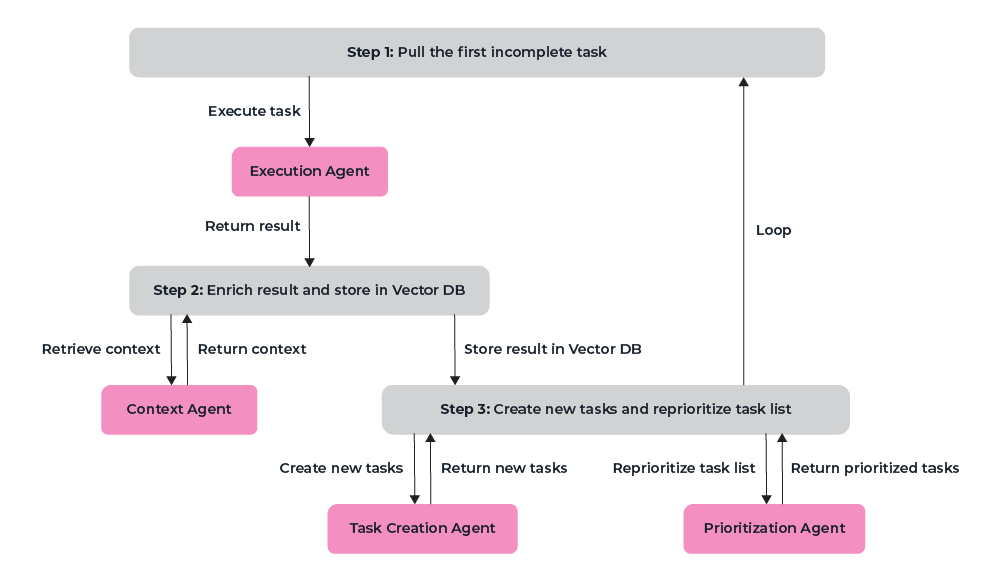 Credit - https://python.langchain.com/en/latest/use_cases/agents/baby_agi_with_agent.html

In [ ]:
from collections import deque
from typing import Dict, List, Optional, Any

from langchain import LLMChain, OpenAI, PromptTemplate
from langchain.embeddings import OpenAIEmbeddings
from langchain.llms import BaseLLM
from langchain.vectorstores.base import VectorStore
from pydantic import BaseModel, Field
from langchain.chains.base import Chain

## Connect to the Vector Store

Depending on what vectorstore you use, this step may look different.

In [ ]:
pip install faiss-cpu google-search-results


In [ ]:
from langchain.docstore import InMemoryDocstore
from langchain.vectorstores.faiss import FAISS


In [ ]:
# Define your embedding model
embeddings_model = OpenAIEmbeddings()
# Initialize the vectorstore as empty
import faiss
embedding_size = 1536
index = faiss.IndexFlatL2(embedding_size)
vectorstore = FAISS(embeddings_model.embed_query, index, InMemoryDocstore({}), {})

## Define the Chains

BabyAGI relies on three LLM chains:
- Task creation chain to select new tasks to add to the list
- Task prioritization chain to re-prioritize tasks
- Execution Chain to execute the tasks


NOTE: in this notebook, the Execution chain will now be an agent.

In [ ]:
class TaskCreationChain(LLMChain):
    """Chain to generates tasks."""

    @classmethod
    def from_llm(cls, llm: BaseLLM, verbose: bool = True) -> LLMChain:
        """Get the response parser."""
        task_creation_template = (
            "You are an task creation AI that uses the result of an execution agent"
            " to create new tasks with the following objective: {objective},"
            " The last completed task has the result: {result}."
            " This result was based on this task description: {task_description}."
            " These are incomplete tasks: {incomplete_tasks}."
            " Based on the result, create new tasks to be completed"
            " by the AI system that do not overlap with incomplete tasks."
            " Return the tasks as an array."
        )
        prompt = PromptTemplate(
            template=task_creation_template,
            input_variables=["result", "task_description", "incomplete_tasks", "objective"],
        )
        return cls(prompt=prompt, llm=llm, verbose=verbose)

In [ ]:
class TaskPrioritizationChain(LLMChain):
    """Chain to prioritize tasks."""

    @classmethod
    def from_llm(cls, llm: BaseLLM, verbose: bool = True) -> LLMChain:
        """Get the response parser."""
        task_prioritization_template = (
            "You are an task prioritization AI tasked with cleaning the formatting of and reprioritizing"
            " the following tasks: {task_names}."
            " Consider the ultimate objective of your team: {objective}."
            " Do not remove any tasks. Return the result as a numbered list, like:"
            " #. First task"
            " #. Second task"
            " Start the task list with number {next_task_id}."
        )
        prompt = PromptTemplate(
            template=task_prioritization_template,
            input_variables=["task_names", "next_task_id", "objective"],
        )
        return cls(prompt=prompt, llm=llm, verbose=verbose)


In [ ]:
from langchain.agents import ZeroShotAgent, Tool, AgentExecutor
from langchain import OpenAI, SerpAPIWrapper, LLMChain
todo_prompt = PromptTemplate.from_template("You are a planner who is an expert at coming up with a todo list for a given objective. Come up with a todo list for this objective: {objective}")
todo_chain = LLMChain(llm=OpenAI(temperature=0), prompt=todo_prompt)
search = SerpAPIWrapper()
tools = [
    Tool(
        name = "Search",
        func=search.run,
        description="useful for when you need to answer questions about current events"
    ),
    Tool(
        name = "TODO",
        func=todo_chain.run,
        description="useful for when you need to come up with todo lists. Input: an objective to create a todo list for. Output: a todo list for that objective. Please be very clear what the objective is!"
    )
]


prefix = """You are an AI who performs one task based on the following objective: {objective}. Take into account these previously completed tasks: {context}."""
suffix = """Question: {task}
{agent_scratchpad}"""
prompt = ZeroShotAgent.create_prompt(
    tools,
    prefix=prefix,
    suffix=suffix,
    input_variables=["objective", "task", "context","agent_scratchpad"]
)

### Define the BabyAGI Controller

BabyAGI composes the chains defined above in a (potentially-)infinite loop.

In [ ]:
def get_next_task(task_creation_chain: LLMChain, result: Dict, task_description: str, task_list: List[str], objective: str) -> List[Dict]:
    """Get the next task."""
    incomplete_tasks = ", ".join(task_list)
    response = task_creation_chain.run(result=result, task_description=task_description, incomplete_tasks=incomplete_tasks, objective=objective)
    new_tasks = response.split('\n')
    return [{"task_name": task_name} for task_name in new_tasks if task_name.strip()]

In [ ]:
def prioritize_tasks(task_prioritization_chain: LLMChain, this_task_id: int, task_list: List[Dict], objective: str) -> List[Dict]:
    """Prioritize tasks."""
    task_names = [t["task_name"] for t in task_list]
    next_task_id = int(this_task_id) + 1
    response = task_prioritization_chain.run(task_names=task_names, next_task_id=next_task_id, objective=objective)
    new_tasks = response.split('\n')
    prioritized_task_list = []
    for task_string in new_tasks:
        if not task_string.strip():
            continue
        task_parts = task_string.strip().split(".", 1)
        if len(task_parts) == 2:
            task_id = task_parts[0].strip()
            task_name = task_parts[1].strip()
            prioritized_task_list.append({"task_id": task_id, "task_name": task_name})
    return prioritized_task_list

In [ ]:
def _get_top_tasks(vectorstore, query: str, k: int) -> List[str]:
    """Get the top k tasks based on the query."""
    results = vectorstore.similarity_search_with_score(query, k=k)
    if not results:
        return []
    sorted_results, _ = zip(*sorted(results, key=lambda x: x[1], reverse=True))
    return [str(item.metadata['task']) for item in sorted_results]

def execute_task(vectorstore, execution_chain: LLMChain, objective: str, task: str, k: int = 5) -> str:
    """Execute a task."""
    context = _get_top_tasks(vectorstore, query=objective, k=k)
    return execution_chain.run(objective=objective, context=context, task=task)

In [ ]:

class BabyAGI(Chain, BaseModel):
    """Controller model for the BabyAGI agent."""

    task_list: deque = Field(default_factory=deque)
    task_creation_chain: TaskCreationChain = Field(...)
    task_prioritization_chain: TaskPrioritizationChain = Field(...)
    execution_chain: AgentExecutor = Field(...)
    task_id_counter: int = Field(1)
    vectorstore: VectorStore = Field(init=False)
    max_iterations: Optional[int] = None

    class Config:
        """Configuration for this pydantic object."""
        arbitrary_types_allowed = True

    def add_task(self, task: Dict):
        self.task_list.append(task)

    def print_task_list(self):
        print("\033[95m\033[1m" + "\n*****TASK LIST*****\n" + "\033[0m\033[0m")
        for t in self.task_list:
            print(str(t["task_id"]) + ": " + t["task_name"])

    def print_next_task(self, task: Dict):
        print("\033[92m\033[1m" + "\n*****NEXT TASK*****\n" + "\033[0m\033[0m")
        print(str(task["task_id"]) + ": " + task["task_name"])

    def print_task_result(self, result: str):
        print("\033[93m\033[1m" + "\n*****TASK RESULT*****\n" + "\033[0m\033[0m")
        print(result)

    @property
    def input_keys(self) -> List[str]:
        return ["objective"]

    @property
    def output_keys(self) -> List[str]:
        return []

    def _call(self, inputs: Dict[str, Any]) -> Dict[str, Any]:
        """Run the agent."""
        objective = inputs['objective']
        first_task = inputs.get("first_task", "Make a todo list")
        self.add_task({"task_id": 1, "task_name": first_task})
        num_iters = 0
        while True:
            if self.task_list:
                self.print_task_list()

                # Step 1: Pull the first task
                task = self.task_list.popleft()
                self.print_next_task(task)

                # Step 2: Execute the task
                result = execute_task(
                    self.vectorstore, self.execution_chain, objective, task["task_name"]
                )
                this_task_id = int(task["task_id"])
                self.print_task_result(result)

                # Step 3: Store the result in Pinecone
                result_id = f"result_{task['task_id']}"
                self.vectorstore.add_texts(
                    texts=[result],
                    metadatas=[{"task": task["task_name"]}],
                    ids=[result_id],
                )

                # Step 4: Create new tasks and reprioritize task list
                new_tasks = get_next_task(
                    self.task_creation_chain, result, task["task_name"], [t["task_name"] for t in self.task_list], objective
                )
                for new_task in new_tasks:
                    self.task_id_counter += 1
                    new_task.update({"task_id": self.task_id_counter})
                    self.add_task(new_task)
                self.task_list = deque(
                    prioritize_tasks(
                        self.task_prioritization_chain, this_task_id, list(self.task_list), objective
                    )
                )
            num_iters += 1
            if self.max_iterations is not None and num_iters == self.max_iterations:
                print("\033[91m\033[1m" + "\n*****TASK ENDING*****\n" + "\033[0m\033[0m")
                break
        return {}

    @classmethod
    def from_llm(
        cls,
        llm: BaseLLM,
        vectorstore: VectorStore,
        verbose: bool = False,
        **kwargs
    ) -> "BabyAGI":
        """Initialize the BabyAGI Controller."""
        task_creation_chain = TaskCreationChain.from_llm(
            llm, verbose=verbose
        )
        task_prioritization_chain = TaskPrioritizationChain.from_llm(
            llm, verbose=verbose
        )
        llm_chain = LLMChain(llm=llm, prompt=prompt)
        tool_names = [tool.name for tool in tools]
        agent = ZeroShotAgent(llm_chain=llm_chain, allowed_tools=tool_names)
        agent_executor = AgentExecutor.from_agent_and_tools(agent=agent, tools=tools, verbose=True)
        return cls(
            task_creation_chain=task_creation_chain,
            task_prioritization_chain=task_prioritization_chain,
            execution_chain=agent_executor,
            vectorstore=vectorstore,
            **kwargs
        )

### Run the BabyAGI

Now it's time to create the BabyAGI controller and watch it try to accomplish your objective.

In [ ]:
OBJECTIVE = "You work for a non profit organization titled Aliens are Real that is trying to find UFOs and aliens among us and give them a warm welcome to Earth. Your goal is to prove Aliens are real through research, first hand accounts, and evidence of extraterrestrial and/or intradimensional life. Your first task in providing evidence that aliens exist is to make a todo list to map out your steps in order to prove aliens are real."

In [ ]:
llm = OpenAI(temperature=0) #less halluciations and more deterministic

In [ ]:
# Logging of LLMChains
verbose=False
# If None, will keep on going forever
max_iterations: Optional[int] = 2
baby_agi = BabyAGI.from_llm(
    llm=llm,
    vectorstore=vectorstore,
    verbose=verbose,
    max_iterations=max_iterations
)

In [ ]:
baby_agi({"objective": OBJECTIVE})